
# Time Series Forecasting using Auto Arima

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, date

# Data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import scipy
# Set font scale and style
plt.rcParams.update({'font.size': 18})

# Stat models
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# import custom class
%run -i '../src/helper/ts.py'

In [3]:
# Instantiate the class
fxn = TimeSeriesForecasting()

# Load  data

In [4]:
ts = pd.read_csv('../data/collision_ts_month.csv') # load data
ts.date = pd.to_datetime(ts['date'])  # convert to datetime
ts.index = ts.date # make date the dataframe index
ts = ts.drop(['date', 'summer_ind'], axis =1)

print("Data size:", ts.shape)
ts.head()

Data size: (228, 11)


,fatality_rate,p_isev_Fatality,p_isev_Injury,p_isev_No Injury,conf_ind_head-on,conf_ind_not-head-on,c_vehs,c_hour,p_age,year,month
date,,,,,,,,,,,
1999-01-01,0.012911,163.0,164.0,89.0,152.0,281.0,2.042258,13.511338,35.239035,1999,1
1999-02-01,0.018163,196.0,176.0,97.0,139.0,343.0,2.006859,13.499924,35.102478,1999,2
1999-03-01,0.020982,219.0,250.0,122.0,149.0,469.0,2.028966,13.507759,34.717830,1999,3
1999-04-01,0.015418,190.0,154.0,83.0,82.0,356.0,2.041576,13.890340,34.662779,1999,4
1999-05-01,0.017953,266.0,248.0,99.0,114.0,523.0,2.037239,13.851641,34.548825,1999,5


##  Create a test  set
We must split the dataset into training and test (out-of-sample) set. We have chosen the test set as the last year's observations (i.e. 2017).


In [5]:
y = ts['fatality_rate']
N = len(y)

exog_variables = list(ts.drop('fatality_rate', axis=1).columns)
X_exog = ts[exog_variables]
X_exog['yearly_seasonality'] = np.arange(N) % 365
X_exog['monthly_seasonality'] = np.arange(N) % 30
# X_exog['weekly_seasonality'] = np.arange(N) % 7

In [6]:
train_start, train_end = '1999-01-01','2014-12-01'
test_start, test_end = '2014-01-01', '2017-12-01'

X_train = X_exog[train_start: train_end]
y_train = y[train_start: train_end]

X_test = X_exog[test_start: test_end]
y_test = y[test_start: test_end]

## Normalization

In [7]:
# Standardization
scaler_y = StandardScaler() 
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)) 

# Normalization 
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# pandas dataframe
X_train_df = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns = X_test.columns)

## SARIMAX
We build Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors (SARIMAX) model using pmdarima‘s auto_arima(). We set seasonal = True, the frequency m = 12 for monthly time series, and seasonal differencing D = 1.

In [8]:
# Train sarimax from auto arima API
sarimax = pm.auto_arima(y_train_scaled, exogenous = X_train_df, max_p = 4, max_q = 4, D = 1, 
                 m=12, test = 'adf', stepwise=True, suppress_warnings=True, error_action='ignore',
                        seasonal= True, random_state= 42, trace = True, n_fits= 20)
sarimax.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1665067.017, Time=4.64 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=196.455, Time=0.39 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=685069.440, Time=5.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=298828.103, Time=2.99 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=523.277, Time=0.90 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1700921.376, Time=5.56 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1097786.188, Time=3.52 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=10556923.903, Time=0.84 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=373983.348, Time=1.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=20678.100, Time=3.15 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=822300.274, Time=1.29 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 30.068 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  192
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                 -84.227
Date:                  Tue, 12 Apr 2022   AIC                            196.455
Time:                          08:09:19   BIC                            241.156
Sample:                               0   HQIC                           214.579
                                  - 192                                         
Covariance Type:                    opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept               -0.0002      0.048     -0.005      0.996      -0.093       0.093
p_isev_Fatality         -2.6229      0.829     -3.164      0.002      -4.247      -0.998
p_isev_Injury           -0.9489      1.156     -0.821      0.412      -3.215       1.318
p_isev_No Injury        -0.6366      0.501     -1.270      0.204      -1.619       0.346
conf_ind_head-on         4.1478      0.814      5.099      0.000       2.553       5.742
conf_ind_not-head-on     9.6939      1.774      5.465      0.000       6.217      13.171
c_vehs                  -0.3315      0.148     -2.233      0.026      -0.622      -0.041
c_hour                   1.0975      0.253      4.336      0.000       0.601       1.594
p_age                    1.5646      0.621      2.521      0.012       0.348       2.781
year                 -1.446e+12      0.003  -4.57e+14      0.000   -1.45e+12   -1.45e+12
month                -8.273e+07   1.19e-16  -6.95e+23      0.000   -8.27e+07   -8.27e+07
yearly_seasonality    1.535e+12      0.003   5.14e+14      0.000    1.53e+12    1.53e+12
monthly_seasonality      0.0132      0.068      0.193      0.847      -0.120       0.147
sigma2                   0.1493      0.016      9.426      0.000       0.118       0.180
===================================================================================
Ljung-Box (L1) (Q):                  16.79   Jarque-Bera (JB):                 4.03
Prob(Q):                              0.00   Prob(JB):                         0.13
Heteroskedasticity (H):               0.83   Skew:                            -0.33
Prob(H) (two-sided):                  0.48   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.88e+21. Standard errors may be unstable.
"""

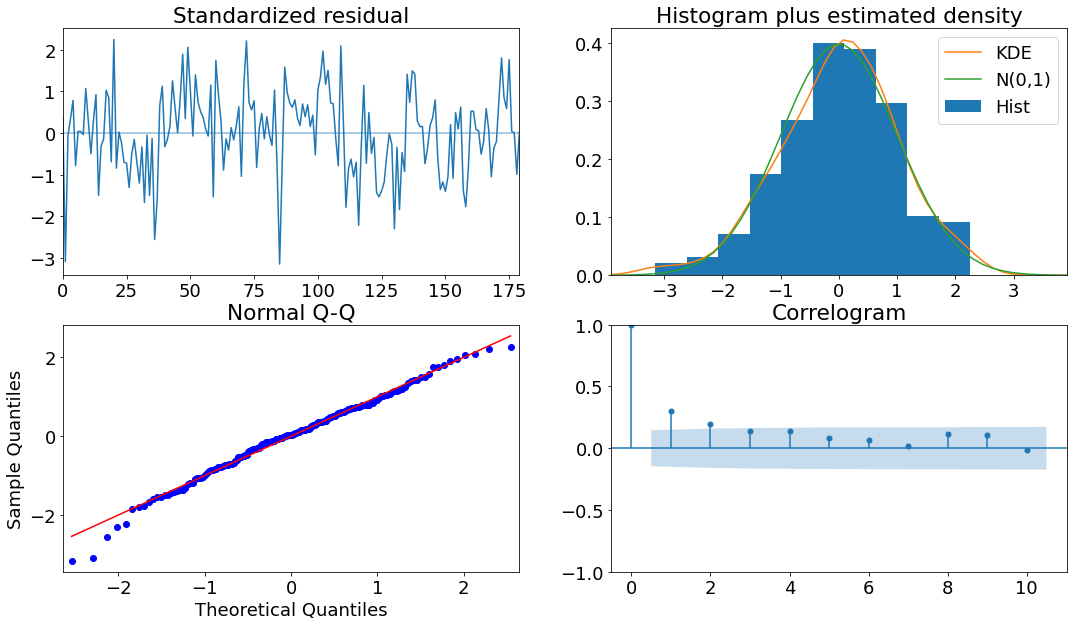

In [9]:
sarimax.plot_diagnostics(figsize=(18,10))
plt.show()

## Test (out-of-sample) prediction

In [10]:
y_pred, conf_int = sarimax.predict(n_periods = len(y_test), exogenous=X_test_df, return_conf_int=True)
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1)).flatten() # Inverse transform scale

## Performance measures (error metrics)

In [11]:
fxn.error_metrics(y_test, y_pred)

{'MAE = 0.001', 'MAPE = 5.167', 'RMSE = 0.001', 'R^2 = 0.836', 'WMAPE = 4.697'}

In [12]:
y_pred[y_pred<0] = 0

y_low = conf_int[:,0]
y_low = scaler_y.inverse_transform(y_low.reshape(-1,1)).flatten()
y_high = conf_int[:,1]
y_high = scaler_y.inverse_transform(y_high.reshape(-1,1)).flatten()

results = pd.DataFrame()
results['y_pred'] = y_pred
results['y_low'] = y_low
results['y_high'] = y_high
results.index = y_test.index

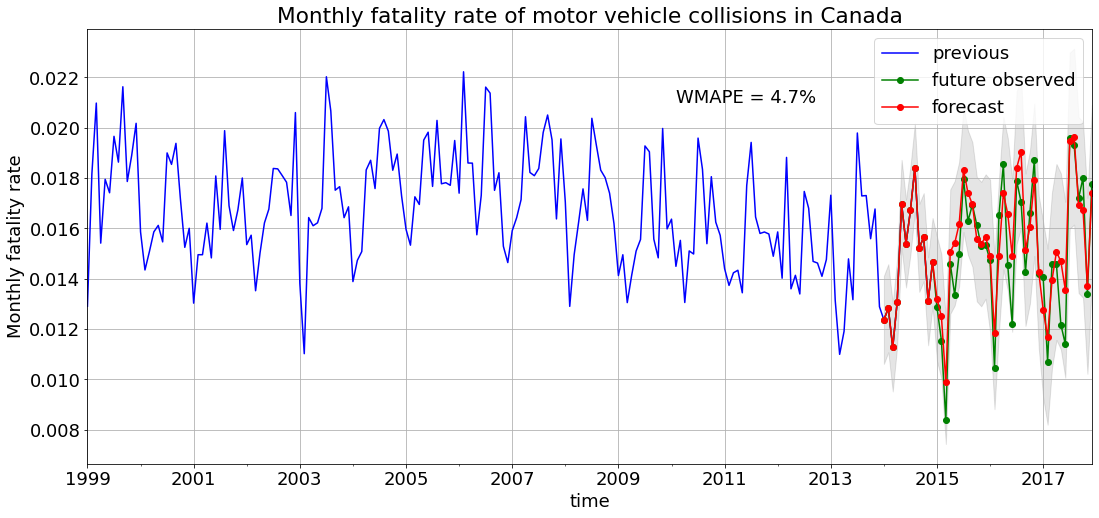

In [20]:
plt.figure(figsize = (18,8))

# y_train.iloc[-len(y_test):].plot(label = 'previous', color = 'b')
y_train.plot(label = 'previous', color = 'b')
y_test.plot(label = 'future observed', marker = 'o', color = 'g')
results['y_pred'].plot(label = 'forecast', marker = 'o', color = 'r')

plt.fill_between(results.index, results['y_low'], results['y_high'], color='k', alpha=0.1)
plt.xlabel('time')
plt.text('2010-02-01', 0.021, "WMAPE = 4.7%")
plt.grid(True)
plt.ylabel('Monthly fatality rate')
plt.title('Monthly fatality rate of motor vehicle collisions in Canada')
plt.legend(loc = 'best')
# plt.savefig('../images/fig_fcst.png')
plt.show()

## Model Diagnostics

## 1. Standadized residual of the test set 

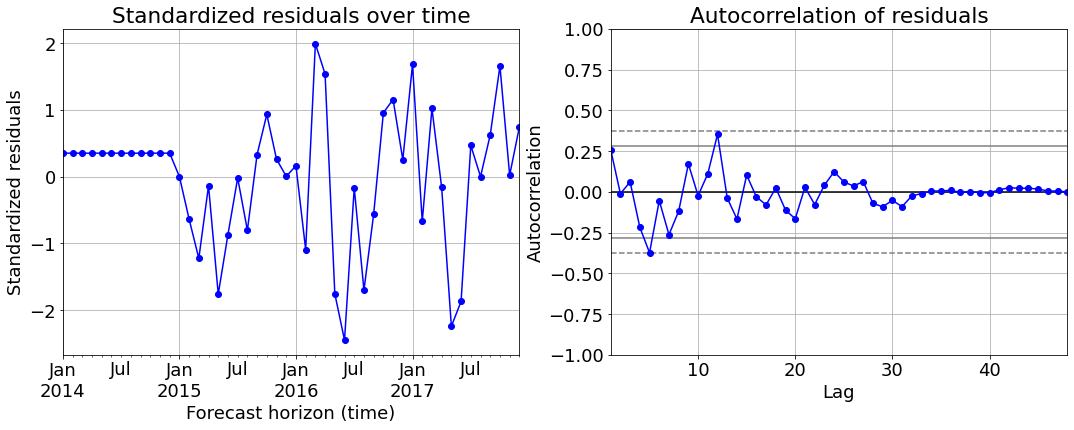

In [14]:
plt.figure(figsize = (18,6))
residual = y_test-results['y_pred']
rstandard = (residual-np.mean(residual))/np.std(residual)

plt.subplot(121)
rstandard.plot(color = 'b', marker = 'o')
plt.grid(True)
plt.xlabel('Forecast horizon (time)')
plt.ylabel('Standardized residuals')
plt.title('Standardized residuals over time')

plt.subplot(122)
pd.plotting.autocorrelation_plot(pd.Series(residual), color = 'b', marker = 'o')
plt.title('Autocorrelation of residuals')
plt.show()

## 2. Ljung-Box test

A good forecasting model will have zero correlation between its residuals. Correlation in residuals means that some information were left out which should have been used in forecasting.

We use the Ljung-Box test to check if the residuals (absolute percent error) from the time series model resemble white noise (i.e., zero autocorrelation). The null hypothesis states that the residuals are independently and identically distributed, that is the errors are uncorrelated. Therefore, a p-value greater than 0.05 means that we do not have enough information (or statistically significant evidence) to reject the null hypothesis. However, this does not mean that the forecasting model cannot be improved.

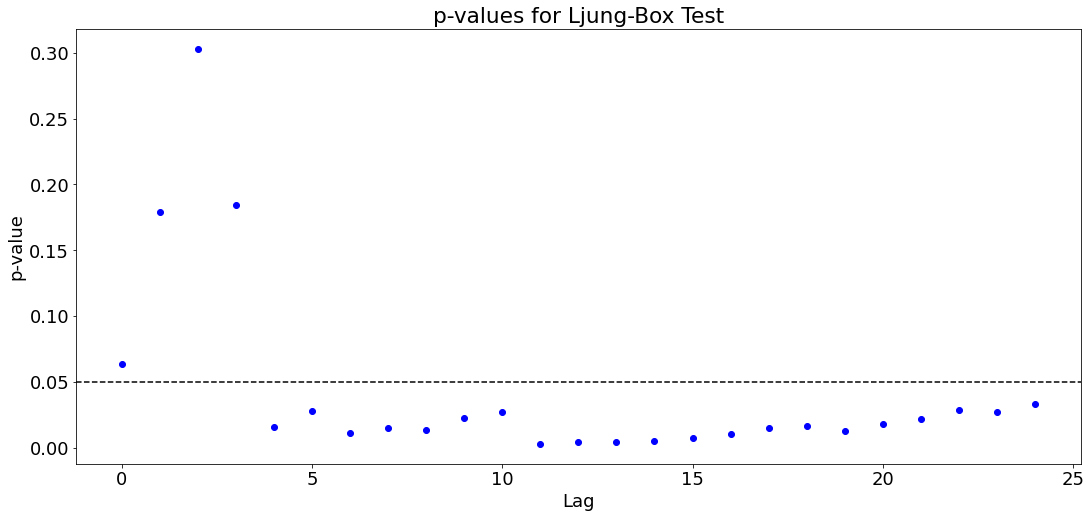

In [15]:
plt.figure(figsize = (18,8))
plt.plot(acorr_ljungbox(residual, lags = 25)[1], 'o', color = 'b')
plt.axhline(y=0.05,linestyle= '--', color = 'k')
plt.ylabel('p-value')
plt.xlabel('Lag')
plt.title('p-values for Ljung-Box Test')
plt.show()